In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn import metrics as mt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve,classification_report,f1_score
from sklearn.pipeline import make_pipeline
sns.set_palette("husl")

c:\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
eopen=pd.read_csv('email_opened_table.csv')
click=pd.read_csv('link_clicked_table.csv')
email=pd.read_csv('email_table.csv')

FileNotFoundError: File b'email_opened_table.csv' does not exist

In [ ]:
len(click)

In [ ]:
click['Clicked'] = 1
eopen['Opened'] = 1

 Question  
* What percentage of users opened the email?
* what percentage clicked on the link within the email?

In [ ]:
merged = email.merge(click, how='outer')
df = eopen.merge(merged, how='outer')
df = df.fillna(0)

In [ ]:
df.head()

In [ ]:
print("Percentage of users opened the email {}%".format(df['Opened'].sum()*100/len(df)))
print("Percentage of clicked on the link within the email {}%".format(df['Clicked'].sum()*100/len(df)))

**Q. The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?**

*Intuition*: The model requested would predict the column clicked and in turn opened. To understand the kind of model and feature to build, we need to perform EDA and preliminary Statistics analysis.


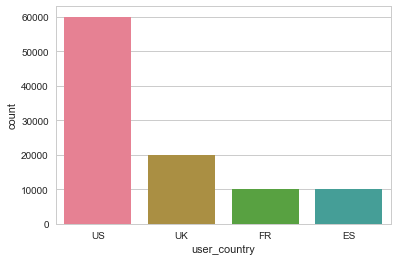

In [6]:
#Users according to country
sns.countplot(x="user_country", data=df)

Looking at individual countries,most of the users have been recorded from United States followed by UK, Frace and Spain. Majority  of the market is in two countries and it wont be wrong to have a higher emphasis on those two.

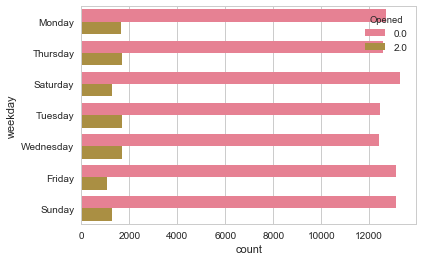

In [7]:
#Users according to weekday
sns.countplot(y="weekday",hue = "Opened", data=df)

Higher number of emails are opened on weekdays(mon-thur) and relatively less on weekends(fri-sun). Possible reasons can be office
workers dont prefer opening emails during weekends or in general, people are less active in checking emails during non working 
days. A possible remedy would be to focus more on sending emails during weekdays over weekends. 

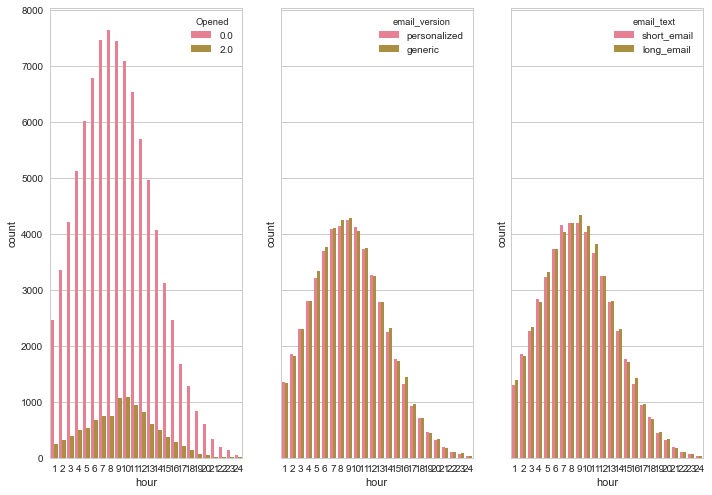

In [8]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(11.7, 8.27)

sns.countplot(x="hour",hue = "Opened", data=df, ax = ax1)
sns.countplot(x="hour",hue = "email_version", data=df, ax = ax2)
sns.countplot(x="hour",hue = "email_text", data=df, ax = ax3)

The distribution is slightly skewed with a higher user activity in the first half as compared to the second half. 

* plot 1- the distributions of emails opened and not opened seem to be quite same. That proposes that higher the number of emails
sent, higher is the number of the email being opened in the recieving end.

* plot 2- The number of  personalized and generic mails sent throughout the day are quite close, though the number of generic
mails are always higher by a significant amount. It would be important to check the effect of kind of email on the number of 
links opened.

* plot 3-In the first half of the day, more number of short emails are sent but that is reversed in the second half of the day. 
A much higher user activity is present in first half as compared to second half. We will see whether a long or short email gets
more clicks from the user.

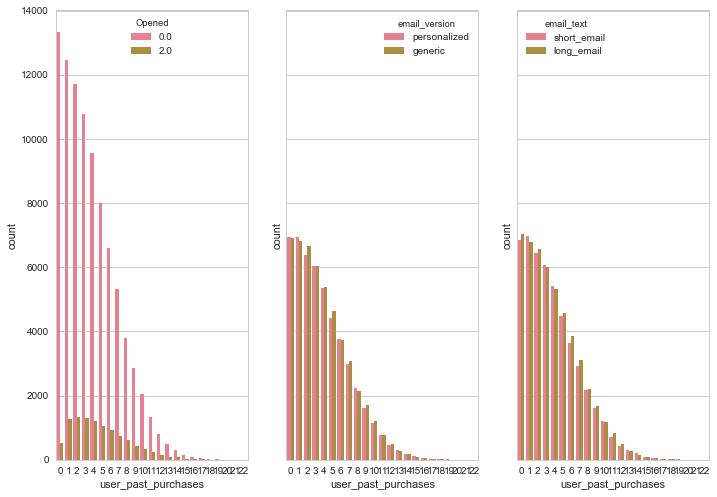

In [9]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(11.7, 8.27)

sns.countplot(x="user_past_purchases",hue = "Opened", data=df, ax = ax1)
sns.countplot(x="user_past_purchases",hue = "email_version", data=df, ax = ax2)
sns.countplot(x="user_past_purchases",hue = "email_text", data=df, ax = ax3)


#### Some Facts about data:
     - Total email ID's : 10,000
     - Number of Unique Countires : 4, Maximum users in US
     - No visual difference in distribution of emails opened 
     - same number of personalised/generic emails sent

#### Chi-Square Testing

In [10]:
# Contigency Table representing Observed Table in %
click_text = pd.crosstab(index=df["email_text"], columns=df["Clicked"],  normalize='index').apply(lambda r: r*100, axis=1)
click_text
#Observation- No visible relation between clicked emails and email text

Clicked,0.0,1.0
email_text,,
long_email,98.146233,1.853767
short_email,97.612823,2.387177


We will conduct a test to determine if there is a relation between the length of email (long/short) with respect to whether 
the user clicks on the link or not.The result will help in determine if there is an clear difference between user responses when
the campaign sends long or short email.

In [11]:
from scipy.stats import chi2_contingency
def chisq_of_df_cols(df, c1, c2):
    ctsum = pd.crosstab(index=df[c1], columns=df[c2])
    return(chi2_contingency(ctsum))
chi2, p, dof, expected = chisq_of_df_cols(df, 'Clicked', 'email_text')
print("Chi value is {} and p-value is {}".format(chi2,p))

Chi value is 34.03743212010791 and p-value is 5.406196945274225e-09


Observation:
* Chi-squared tests provide a way to investigate differences in the distributions of categorical variables with the same categories and the dependence between categorical variables.
* As the p-value is less than 0.05, we can conclude that the variables are dependent. 
* Examining the pattern of numbers it is noted that more emails whether long or short emails choose not to click them.

*Note*: The degrees of freedom for a test of independence equals the product of the number of categories in each variable minus 

In [12]:
from itertools import combinations
L = ['email_text', 'email_version', 'weekday', 'user_country',  'Clicked']
tup = [(comb) for comb in combinations(L, 2)]
row = []
for t in tup:
    result = chisq_of_df_cols(df,t[0], t[1])
    if result[1]>0.05:
        r = "accept Null"
    else:
        r = "Reject Null"
    row.append(pd.Series({'Var1': t[0], 'Var2': t[1], 'chi2': result[0], 'p': result[1], 'Result': r}))
Chi_result = pd.DataFrame(row)


In [13]:
Chi_result

,Result,Var1,Var2,chi2,p
0,accept Null,email_text,email_version,0.006921,9.336979e-01
1,accept Null,email_text,weekday,3.865520,6.948693e-01
2,accept Null,email_text,user_country,0.700005,8.732028e-01
3,Reject Null,email_text,Clicked,34.037432,5.406197e-09
4,Reject Null,email_version,weekday,13.481748,3.599263e-02
5,accept Null,email_version,user_country,1.017662,7.969783e-01
6,Reject Null,email_version,Clicked,177.562629,1.650505e-40
7,accept Null,weekday,user_country,14.308473,7.087722e-01
8,Reject Null,weekday,Clicked,103.230664,5.310038e-20
9,Reject Null,user_country,Clicked,204.082662,5.533103e-44


*The following pairs namely (email_text,email_version),(email_text,weekday),(email_text,user_country) etc are variables which is 
company dependent and not user dependent, which means that it is the campaigns choice which type of email (long/short) to send where (country)
and when (time/weekday). The fact that the chi square test fails in these pairs prove there is no relation between these individual pairs. 
This in fact, concludes that currently there is no strategy used by the company. The type of emails, frequency and user 
destination are chosen at random without any prior data driven decision. 

*The next lot of pairs which are user depended (email_text,clicked),(weekday,clicked) are the pairs where null hypothesis has been
rejected which means that these pairs are related. There is a relation between the type of email sent with whether the user clicks
on it and which day the email has been sent.

*An effective strategy will involve which countries to target combined with the type of emails to send and which perticular days 
and hours. US and UK are the places with highest number of users. There is a higher activity during the first half of the day as
compared to second half. Moreover,users are more susceptible to open emails during weekdays as compared to weekends. 

#### Anova Tests

In [14]:
df.head()

,email_id,Opened,email_text,email_version,hour,weekday,user_country,user_past_purchases,Clicked
0,284534,2.0,short_email,personalized,7,Monday,US,6,1.0
1,609056,2.0,short_email,personalized,2,Thursday,US,6,1.0
2,220820,2.0,short_email,personalized,8,Monday,UK,4,1.0
3,905936,2.0,short_email,generic,14,Saturday,UK,3,1.0
4,164034,2.0,long_email,personalized,2,Thursday,US,11,1.0


c:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


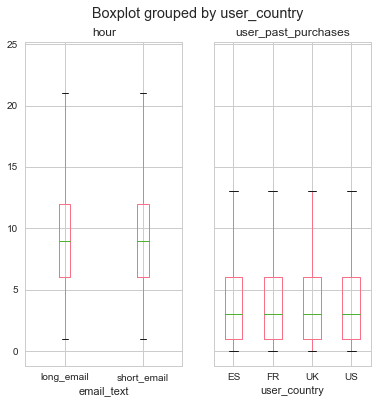

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(6, 6)
df.boxplot('hour', by='email_text', ax= ax1)
df.boxplot('user_past_purchases', by='user_country', ax= ax2)

In [16]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_lm = ols('user_past_purchases ~ C(email_text) + C(user_country) + C(weekday) + C(Clicked)',data=df).fit()
print(sm.stats.anova_lm(df_lm, typ=2))


c:\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                       sum_sq       df            F         PR(>F)
C(email_text)    2.788606e+01      1.0     2.761191   9.657947e-02
C(user_country)  1.837732e+02      3.0     6.065550   4.009211e-04
C(weekday)       1.258783e+02      6.0     2.077346   5.239141e-02
C(Clicked)       1.148738e+04      1.0  1137.444399  5.990236e-248
Residual         1.009808e+06  99988.0          NaN            NaN


*Observations*
* email_text, weekday and User past purchase are dependent
* user_country,clicked and User Past Purchase are independent features

There is no relation between the customer's past purchase history and the email text sent to them, as the p value is 
higher than threshold. That means that company did not consider before sending the type of email text and version to the customer, if the customer has had a high or low purchase in the past.The same goes for Weekday. Yet again, an effective strategy
would be to send short emails to users in France, Uk and USA on weekdays and long emails to users in Spain.

### Feature Selection
To effectively understand which features effect the click through rate, I'll aggregate the *Clicked* values to calculate the Clicked Through Rate (CTR) 

In [7]:
def get_plot_ctr(feature, hue = None ):
    if len(feature) < 2:
        res = df.groupby(feature).mean()
        g = sns.factorplot(x= res.index, y="Clicked", data=res, size=6, kind="bar", palette="muted")
    else:
        res = df.groupby(feature).mean().reset_index(level=[0,1])
        g = sns.factorplot(x= feature[0], y="Clicked", hue = hue, data=res, size=6, kind="bar", palette="muted")
    g.despine(left=True)
    g.set_ylabels("Click Through Rate")



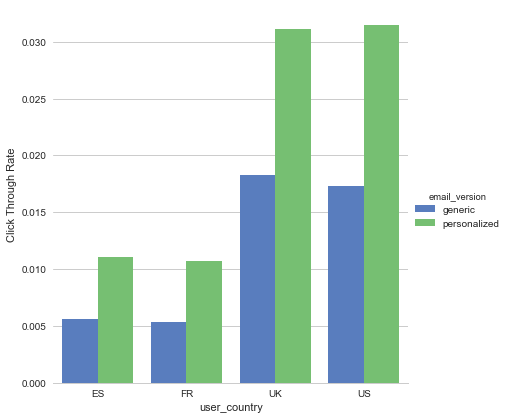

In [154]:
#Click Rate V/S User Country 
get_plot_ctr(["user_country","email_version"], hue = "email_version")

The personalised version of emails have a higher click through rate. We don't know if the emails send to users in non- English speaking country is in a different language or not. This might lead to a poor performance in English- Non- English speaking country.

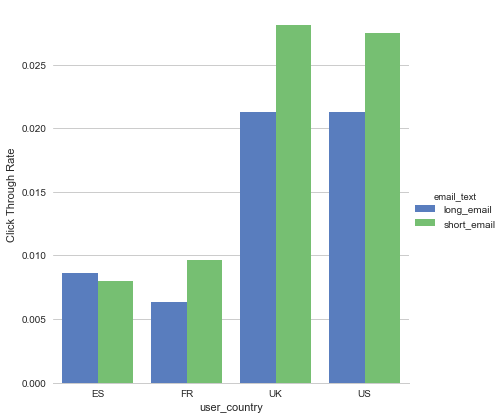

In [121]:
#Country
get_plot_ctr(["user_country","email_text"], hue = "email_text")

Long emails are clearly at the losing ends in France, UK and US. However, more number of users have clicked long emails in Spain.
There is no way to determine the reason for that due to the limitation of data fields. However, if the company were to act on it,
there should be a higher emphasis on longer emails when sent to Spanish users.

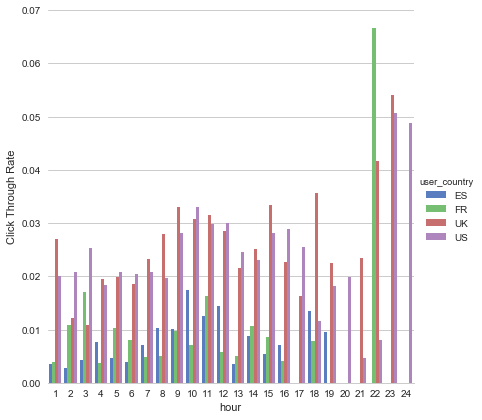

In [149]:
#Country
get_plot_ctr(["hour", "user_country"], hue = "user_country")
# Pe

No conclusive reasoning can be found in the above plot. Different countries have different timezones and emails should be sent accordingly. No such definitive pattern is visible right now

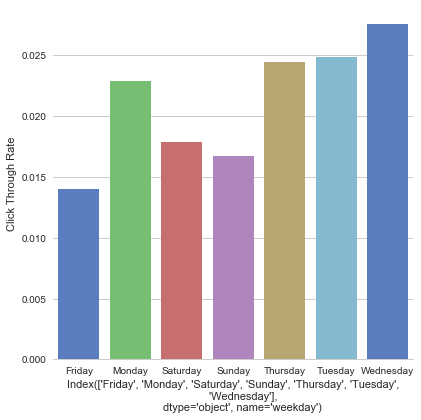

In [155]:
get_plot_ctr(["weekday"])


We are going to club Friday, Saturday and Sunday in *weekend* category and the rest of the days in *weekday*

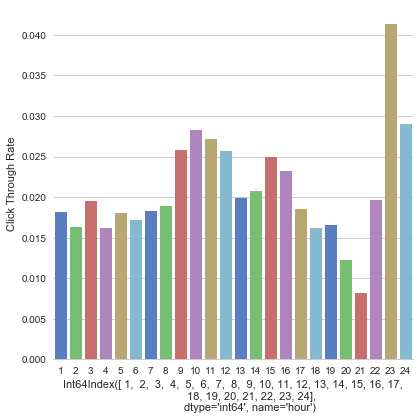

In [156]:
get_plot_ctr(["hour"])


There seems no direct correlation between sending hour and CTR. More data is required for a conclusion. As a result I won't be using *sending hour* as a feature in our model

**Feature Selection** - For our model we will use - weekday, email_version, email_text, user_past_purchases, user_Country

### Predictive Model
We now develop a predictive model to predict whether a user will open the email and click the link inside it.

In [150]:
# User_country is an ordinal categorical variable. Based on our past analysis, I'll convert them into English speaking and non- Englis speaking
df = df.replace(["US", "UK"], "eng")
df = df.replace(["ES", "FR"], "Non-Eng")
#Club weekdays and weekend
df = df.replace(["Monday", "Thursday","Tuesday","Wednesday"], "wday")
df = df.replace(["Friday", "Saturday","Sunday"], "wend")


In [151]:
data = pd.get_dummies(df, columns=['user_country', 'weekday',"email_version","email_text"]).drop(["hour","email_id"], axis = 1)

In [152]:
y = (data.Clicked).astype(int)
data = data.drop(["Clicked", "Opened"], axis = 1)

In [153]:
ytrain.value_counts()

0    65300
1     1367
Name: Clicked, dtype: int64

In [154]:
Xtrain.head()

,Opened,user_past_purchases,Clicked,user_country_Non-Eng,user_country_eng,weekday_wday,weekday_wend,email_version_generic,email_version_personalized,email_text_long_email,email_text_short_email
17903,0.0,11,0.0,0,1,1,0,0,1,1,0
85189,0.0,1,0.0,0,1,0,1,1,0,0,1
11838,0.0,6,0.0,1,0,0,1,1,0,1,0
93059,0.0,7,0.0,0,1,0,1,0,1,0,1
24934,0.0,3,0.0,1,0,0,1,0,1,0,1


In [155]:
seed = 4999
# split for training and testing

Xtrain,Xtest,ytrain,ytest = train_test_split(data,y,test_size=0.33333,random_state = seed)
print ('Train set shape: {}, positive ratio={:.3f}'.format(Xtrain.shape,ytrain.mean()))
print ('Test set shape: {}, positive ratio={:.3f}'.format(Xtest.shape,ytest.mean()))

Train set shape: (66667, 9), positive ratio=0.021
Test set shape: (33333, 9), positive ratio=0.023


In [156]:
# rescale weight to make it same as test set
weight = Xtrain.iloc[:,8] * float(len(Xtest)) / 2
label = [1.0,0.0]
weight = weight.reset_index(drop=True)
ytrain = ytrain.reset_index(drop=True)

In [157]:
weight[1]

16666.5

In [158]:
sum_wpos = sum( weight[i] for i in range(len(ytrain)) if ytrain[i] == 1.0  )
sum_wneg = sum( weight[i] for i in range(len(ytrain)) if ytrain[i] == 0 )
# print weight statistics
print ('weight statistics: wpos=%g, wneg=%g, ratio=%g' % ( sum_wpos, sum_wneg, sum_wneg/sum_wpos ))

weight statistics: wpos=1.27999e+07, wneg=5.40945e+08, ratio=42.2617


In [159]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics 

In [160]:
def modelfit(alg, dtrain,y,dtest,y_test ,weight,sum_wneg,sum_wpos, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    # scale weight of positive examples
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=y.values,weight = weight,missing = -999.0)
        cvresult = xgb.cv(xgb_param, xgtrain, nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, y,eval_metric='auc')
        
    #Predict testing set:
    dtest_predictions = alg.predict(dtest)
    dtest_predprob = alg.predict_proba(dtest)[:,1]
    #print(dtrain_predictions)
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test.values, dtest_predictions.round(),normalize =  False))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtest_predprob))
                   
    xgb.plot_importance(alg)

    import scikitplot as skplt
    import matplotlib.pyplot as plt
    skplt.metrics.plot_roc_curve(y_test, alg.predict_proba(dtest))
    plt.show()
    print(classification_report(y_test.values,dtest_predictions.round()))
    print(f1_score(y_test.values, dtest_predictions.round(), average='weighted', labels=np.unique(dtest_predictions.round())))
    return alg,dtest_predictions,dtest_predprob

C:\Users\dranjan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\dranjan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)



Model Report
Accuracy : 2.254e+04
AUC Score (Test): 0.736410


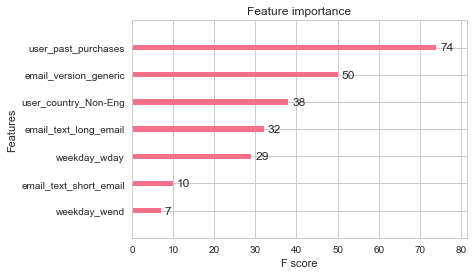

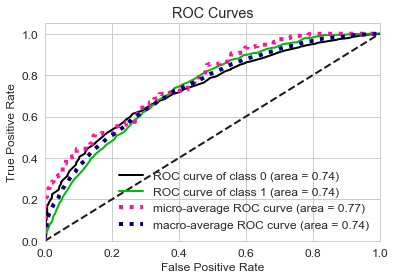

             precision    recall  f1-score   support

          0       0.99      0.68      0.80     32581
          1       0.04      0.66      0.08       752

avg / total       0.97      0.68      0.79     33333

0.7870741955857956


In [161]:
xgb1 = XGBClassifier(learning_rate =0.1,
 max_depth=5,
 min_child_weight=1,
early_stopping_rounds = 30,
 gamma=0,scale_pos_weight =  sum_wneg/sum_wpos,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,)
fit_model,presictions, pred_probab = modelfit(xgb1, Xtrain,ytrain,Xtest, ytest,weight,sum_wneg,sum_wpos)

In [39]:
unique, counts = np.unique(presictions, return_counts=True)

In [40]:
dict(zip(unique, counts))

{0: 33333}